In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

np.random.seed(42)


In [2]:
# ------------------------
# Users
# ------------------------
n_users = 1000

users = pd.DataFrame({
    "user_id": range(n_users),
    "segment": np.random.choice(
        ["low", "normal", "power"],
        size=n_users,
        p=[0.4, 0.4, 0.2]
    )
})

segment_engagement = {
    "low": 0.2,
    "normal": 0.4,
    "power": 0.7
}

users["baseline_engagement"] = users["segment"].map(segment_engagement)
users["baseline_engagement"] += np.random.normal(0, 0.05, n_users)
users["baseline_engagement"] = users["baseline_engagement"].clip(0, 1)

# non-random feature exposure (selection bias)
users["feature_flag"] = np.where(
    np.random.rand(n_users) < users["baseline_engagement"],
    "new_feature",
    "control"
)

# ------------------------
# Engagement events
# ------------------------
events = []

for _, row in users.iterrows():
    cards = np.random.poisson(5 if row["feature_flag"] == "new_feature" else 2)
    for _ in range(cards):
        events.append({"user_id": row["user_id"]})

events = pd.DataFrame(events)


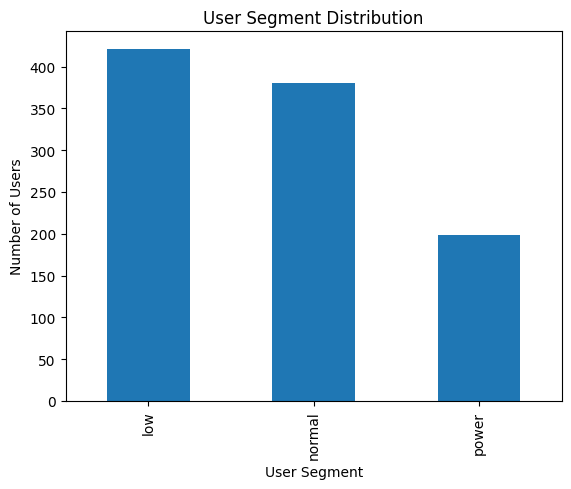

In [3]:
segment_counts = users["segment"].value_counts()

plt.figure()
segment_counts.plot(kind="bar")
plt.title("User Segment Distribution")
plt.xlabel("User Segment")
plt.ylabel("Number of Users")
plt.show()


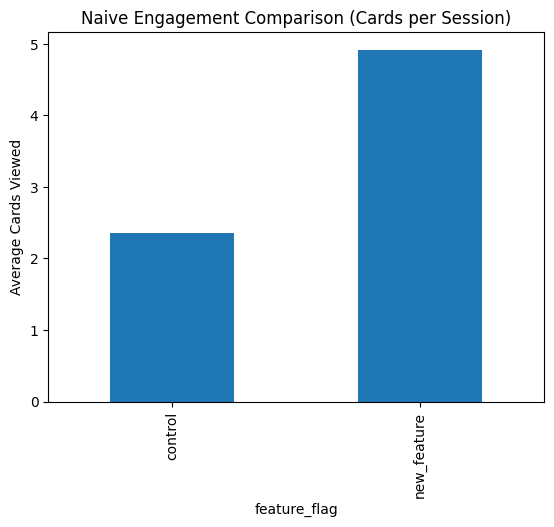

feature_flag
control        2.353271
new_feature    4.919355
Name: cards_per_session, dtype: float64

In [4]:
engagement = (
    events.groupby("user_id")
    .size()
    .reset_index(name="cards_per_session")
    .merge(users, on="user_id")
)

naive_means = engagement.groupby("feature_flag")["cards_per_session"].mean()

plt.figure()
naive_means.plot(kind="bar")
plt.title("Naive Engagement Comparison (Cards per Session)")
plt.ylabel("Average Cards Viewed")
plt.show()

naive_means


In [5]:
users["retained_7d"] = (
    users["baseline_engagement"] +
    np.random.normal(0, 0.1, n_users)
) > 0.35

users["retained_7d"] = users["retained_7d"].astype(int)


In [6]:
users["treatment"] = (users["feature_flag"] == "new_feature").astype(int)

X = users[["baseline_engagement"]]
y = users["treatment"]

ps_model = LogisticRegression()
ps_model.fit(X, y)

users["propensity"] = ps_model.predict_proba(X)[:, 1]


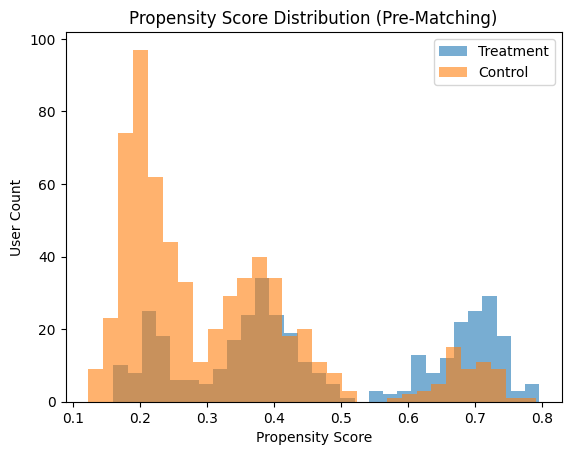

In [7]:
plt.figure()
plt.hist(users[users["treatment"] == 1]["propensity"], bins=30, alpha=0.6, label="Treatment")
plt.hist(users[users["treatment"] == 0]["propensity"], bins=30, alpha=0.6, label="Control")
plt.title("Propensity Score Distribution (Pre-Matching)")
plt.xlabel("Propensity Score")
plt.ylabel("User Count")
plt.legend()
plt.show()


In [8]:
treated = users[users["treatment"] == 1]
control = users[users["treatment"] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[["propensity"]])

distances, indices = nn.kneighbors(treated[["propensity"]])
matched_control = control.iloc[indices.flatten()]

matched = treated.copy()
matched["control_retained"] = matched_control["retained_7d"].values


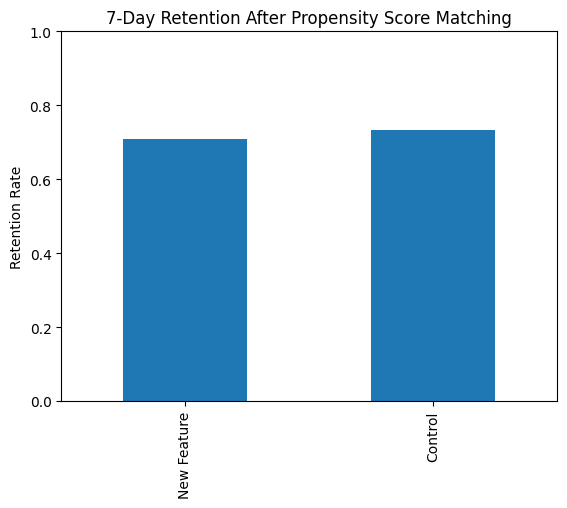

New Feature    0.707775
Control        0.734584
dtype: float64

In [9]:
retention_means = pd.Series({
    "New Feature": matched["retained_7d"].mean(),
    "Control": matched["control_retained"].mean()
})

plt.figure()
retention_means.plot(kind="bar")
plt.title("7-Day Retention After Propensity Score Matching")
plt.ylabel("Retention Rate")
plt.ylim(0, 1)
plt.show()

retention_means


In [10]:
matched["segment"] = users.loc[matched.index, "segment"].values
matched["control_segment"] = matched_control["segment"].values

segment_retention = (
    matched.groupby("segment")[["retained_7d", "control_retained"]]
    .mean()
)

segment_retention


,retained_7d,control_retained
segment,,
low,0.082192,0.150685
normal,0.734177,0.765823
power,1.000000,1.000000


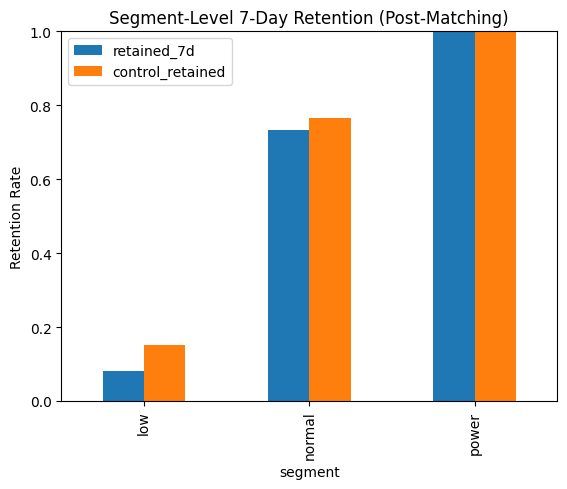

In [11]:
segment_retention.plot(kind="bar")
plt.title("Segment-Level 7-Day Retention (Post-Matching)")
plt.ylabel("Retention Rate")
plt.ylim(0, 1)
plt.show()
